In [20]:
# Use short-window cross-correlation to find the P-S differential travel time

## Importing modules

from matplotlib import pyplot as plt
from obspy import read, UTCDateTime
from snuffler_utils import read_picks
from preproc_utils import preprocess_stream
from cc_utils import get_slidecc, detect_arrival_ccval, get_psdifftime_slidecc
from os.path import join
import pandas as pd
import numpy as np

In [21]:
## Inputs

stname = "A04"
root = "/Volumes/OmanData/geophones_no_prefilt/data"
timewin_tmp = "2020-01-12-17-00-00"
evname_tmp = "Example1"
evname_targ = "SimilarEvent1"

difftime_start = -10
end = 200
freqmin = 10
freqmax = 200

winlen_long = 50 # Long window length in point
winlen_short = 20 # Short window length in point
maxshift_delta = 5 # Maximum allowed shift between the master and target evengts in point

winlen_slope = 10 # Window length for the slope calculation
maxshift_psdiff = 100 # Maximum allowed shift for the P-S differential travel time in point


In [22]:
## Read the template event information
inpath = join(root, timewin_tmp, f"Ppicks_{evname_tmp}.dat")
tmpdf = read_picks(inpath)

In [23]:
## Read the targilar event information
inpath = join(root, timewin_tmp, f"{evname_targ}_{evname_tmp}.csv")
targdf = pd.read_csv(inpath, sep=" ", index_col=0)
numst_targ = len(targdf)

In [24]:
## Read and process the template event 
inpath = join(root, timewin_tmp, f"*{stname}*.SAC")
tempstr = read(inpath)

tempstr = preprocess_stream(tempstr, freqmin, freqmax)

## Trim the template event to the time window of interest
tmpdf = tmpdf.loc[tmpdf["station"] == stname]
tmpdf.reset_index(inplace=True, drop=True)
starttime = UTCDateTime(tmpdf["datetime"][0])
tempstr.trim(starttime, starttime + end/1000)


3 Trace(s) in Stream:
7F.A04..GH1 | 2020-01-12T17:29:40.894109Z - 2020-01-12T17:29:41.094109Z | 1000.0 Hz, 201 samples
7F.A04..GH2 | 2020-01-12T17:29:40.894109Z - 2020-01-12T17:29:41.094109Z | 1000.0 Hz, 201 samples
7F.A04..GHZ | 2020-01-12T17:29:40.894109Z - 2020-01-12T17:29:41.094109Z | 1000.0 Hz, 201 samples

In [25]:
## Read and process the target event
targdf = targdf.loc[targdf["station"] == stname]
targdf.reset_index(inplace=True, drop=True)
starttime = UTCDateTime(targdf["peak_time"][0])
timewin_targ = starttime.strftime("%Y-%m-%d-%H-00-00")

inpath = join(root, timewin_targ, f"*{stname}*.SAC")
targstr = read(inpath)

targstr = preprocess_stream(targstr, freqmin, freqmax)

## Trim the targilar event to the time window of interest
targstr.trim(starttime+difftime_start/1000, starttime + end/1000)

3 Trace(s) in Stream:
7F.A04..GH1 | 2020-01-12T17:27:32.639101Z - 2020-01-12T17:27:32.849101Z | 1000.0 Hz, 211 samples
7F.A04..GH2 | 2020-01-12T17:27:32.639101Z - 2020-01-12T17:27:32.849101Z | 1000.0 Hz, 211 samples
7F.A04..GHZ | 2020-01-12T17:27:32.639101Z - 2020-01-12T17:27:32.849101Z | 1000.0 Hz, 211 samples

In [26]:
## Compute the sliding-window cc using the long window
# psdifftime, steps, deltas, longccs, shortccs = get_psdifftime_wincc(tempstr, targstr, npts_long=20, npts_short=20)
steps_long, deltas_long, ccvals_long = get_slidecc(tempstr, targstr, difftime_start, winlen=winlen_long)

In [27]:
## Find the P-S differential travel time using the short window
step_psdiff, uncer, steps_short, deltas_short, ccvals_short, steps_slope, slopes, maxslope = get_psdifftime_slidecc(tempstr, targstr, difftime_start, winlen_cc=winlen_short, winlen_slope=winlen_slope, maxshift_delta=maxshift_delta, maxshift_psdiff=maxshift_psdiff)

P-S differential travel time derived using the cc values: 50 +/- 6 ms


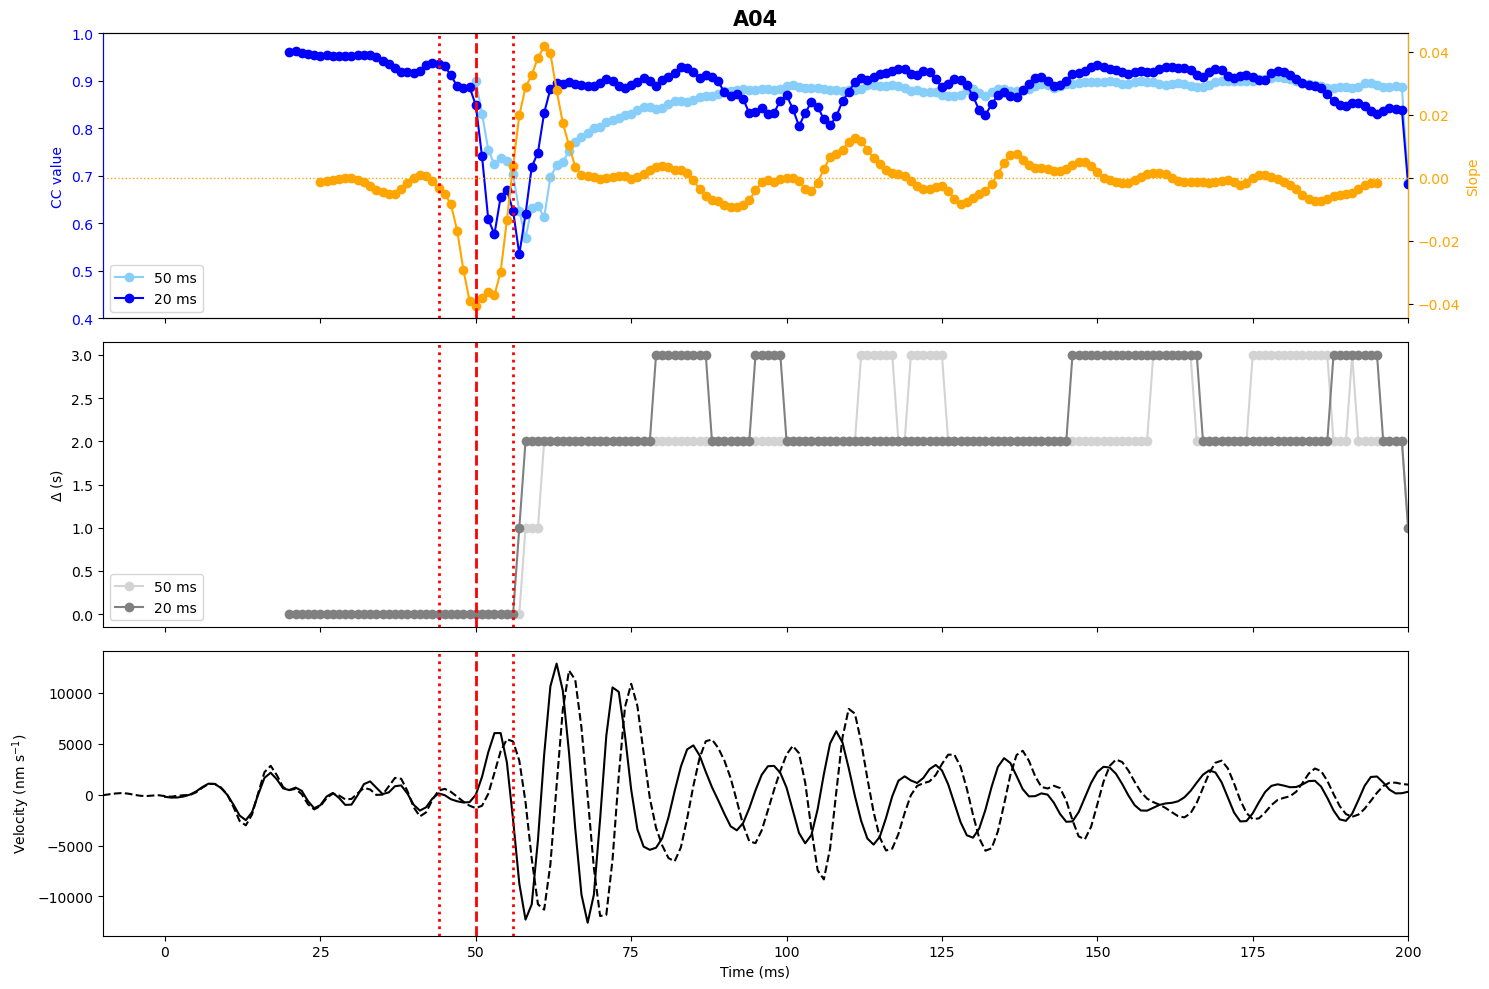

In [28]:
## Plot the deltas as functions of time shifts
dt = tempstr[0].stats.delta

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

### CC values
ax1 = axes[0]

ax1.plot(steps_long, ccvals_long, linestyle="-", marker="o", color="lightskyblue", label="50 ms")
ax1.plot(steps_short, ccvals_short, linestyle="-", marker="o", color="blue", label="20 ms")
ax1.set_ylim(0.4, 1.0)
ax1.set_xlim(difftime_start*1000, end*1000)

ax1.set_ylabel("CC value", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax1.legend(loc="lower left")

ax2 = ax1.twinx()

ax2.scatter(steps_slope, slopes, marker="o", color="orange")
ax2.plot(steps_slope, slopes, color="orange")

ax2.axvline(step_psdiff, color="red", linestyle="--", linewidth=2)
ax2.axvline(step_psdiff+uncer, color="red", linestyle=":", linewidth=2)
ax2.axvline(step_psdiff-uncer, color="red", linestyle=":", linewidth=2)

ax2.axhline(0, color="orange", linestyle=":", linewidth=1)

ax2.set_ylabel("Slope", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

ax2.spines['left'].set_color("blue")
ax2.spines['right'].set_color("orange")

ax2.set_title(f"{stname}", fontsize=15, fontweight="bold")

### Deltas 
ax3 = axes[1]

ax3.plot(steps_long, deltas_long, linestyle="-", marker="o", color="lightgray", label="50 ms")
ax3.plot(steps_short, deltas_short, linestyle="-", marker="o", color="gray", label="20 ms")

ax3.axvline(step_psdiff, color="red", linestyle="--", linewidth=2)
ax3.axvline(step_psdiff+uncer, color="red", linestyle=":", linewidth=2)
ax3.axvline(step_psdiff-uncer, color="red", linestyle=":", linewidth=2)

ax3.set_xlim(difftime_start, end)
ax3.set_ylabel("$\Delta$ (s)", color="black")

ax3.legend(loc="lower left")

### Waveforms
temptrc_z  = tempstr.select(channel="*Z")[0]
template_z = temptrc_z.data
timeax_tmp = temptrc_z.times()*1000

targtrc_z  = targstr.select(channel="*Z")[0]
target_z  = targtrc_z.data
timeax_targ = targtrc_z.times()*1000+difftime_start

ax4 = axes[2]
ax4.plot(timeax_tmp, template_z, color="black")
ax4.plot(timeax_targ, target_z, color="black", linestyle="--")
ax4.set_xlabel("Time (ms)")
ax4.set_ylabel("Velocity (nm s$^{-1}$)")

ax4.axvline(step_psdiff, color="red", linestyle="--", linewidth=2)
ax4.axvline(step_psdiff+uncer, color="red", linestyle=":", linewidth=2)
ax4.axvline(step_psdiff-uncer, color="red", linestyle=":", linewidth=2)

### Save the figure
fig.tight_layout()
outpath = join(root, timewin_tmp, f"PSdifftime_{evname_tmp}_{stname}.png")
fig.savefig(outpath, dpi=300, transparent=True)